In [1]:
import pandas as pd
import numpy as np
import yaml
import networkx as nx
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
from dag_gettsim.dag import compute_taxes_and_transfers

In [3]:
from gettsim.pre_processing.policy_for_date import get_policies_for_date

In [4]:
df = pd.read_csv("gettsim/tests/test_dfs_ssc.csv")
params = yaml.safe_load(
    Path("gettsim", "soz_vers_beitr.yaml").read_text(encoding="utf-8")
)

In [5]:
year_df = df.query("jahr == 2002")[[
    "p_id",
    "hh_id",
    "tu_id",
    "bruttolohn_m",
    "wohnort_ost",
    "alter",
    "selbstständig",
    "hat_kinder",
    "eink_selbstst_m",
    "ges_rente_m",
    "prv_krankv_beit_m",
    "jahr",]
]

In [6]:
year_params = get_policies_for_date(year=2002, group="soz_vers_beitr", raw_group_data=params)

In [7]:
data, dag = compute_taxes_and_transfers(
    dict(year_df), params=year_params, targets=["sozialv_beit_m"], return_dag=True)

In [8]:
data

12    144.55
Name: sozialv_beit_m, dtype: float64

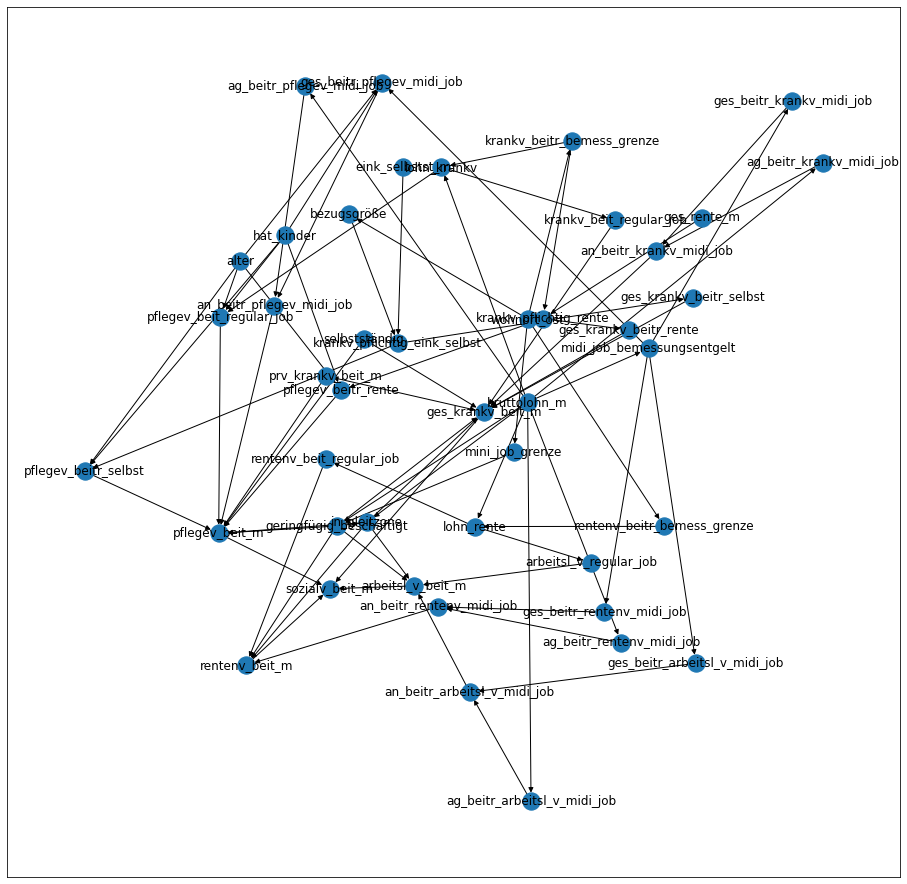

In [9]:
fig, ax = plt.subplots(figsize=(16, 16))

nx.draw_networkx(dag, ax=ax)

In [10]:
list(dag.predecessors("sozialv_beit_m"))

['pflegev_beit_m', 'ges_krankv_beit_m', 'rentenv_beit_m', 'arbeitsl_v_beit_m']